In [1]:
from __future__ import print_function, division, unicode_literals
%load_ext autoreload
%autoreload 2
import os
import re
import random
import io
import json
from io import open
import dill

from matplotlib import pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import distributions as pyd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import pickle
import numpy as np
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm

In [2]:
# Custom weight init for Conv2D and Linear layers
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.orthogonal_(m.weight.data)
        if hasattr(m.bias, "data"):
            m.bias.data.fill_(0.0)

class Flatten(nn.Module):
    def forward(self, x):
        return x.reshape(x.size(0), -1)
        
class BCPolicy(nn.Module):
    def __init__(
        self, action_dim, hidden_size, output_mod=None):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=8, stride=4), nn.ReLU(inplace=True), # 119,159
            nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(inplace=True), # 58, 78
            nn.Conv2d(64, 32, kernel_size=3, stride=1), nn.LeakyReLU(inplace=True), Flatten(), # 4256
            nn.Linear(4256, 1000),
            nn.Linear(1000, act_size))
        self.apply(weight_init)

    def forward(self, state):
        state = state/255.0 # process image + switch channels
        action = self.cnn(state)
        return action

In [237]:
trajs = []
data = dill.load(open('drill_trash.pkl','rb'))
trajs.append(data)

In [211]:
num_tasks = len(trajs)

act_size = 12
hidden_size = 100

policy = BCPolicy(hidden_size, 9)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy.to(device)

BCPolicy(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Flatten()
    (7): Linear(in_features=4256, out_features=1000, bias=True)
    (8): Linear(in_features=1000, out_features=12, bias=True)
  )
)

[1,     1] loss: 1.24336100
[2,     1] loss: 0.88649279
[3,     1] loss: 0.76287216
[4,     1] loss: 0.40527943
[5,     1] loss: 0.28785557
[6,     1] loss: 0.23656084
[7,     1] loss: 0.30855554
[8,     1] loss: 0.33363348
[9,     1] loss: 0.26903078
[10,     1] loss: 0.22490883
[11,     1] loss: 0.16052426
[12,     1] loss: 0.09818491
[13,     1] loss: 0.13668361
[14,     1] loss: 0.14977659
[15,     1] loss: 0.15190949
[16,     1] loss: 0.12307631
[17,     1] loss: 0.06851153
[18,     1] loss: 0.06993027
[19,     1] loss: 0.07703467
[20,     1] loss: 0.09552602
[21,     1] loss: 0.08602147
[22,     1] loss: 0.07147261
[23,     1] loss: 0.03730166
[24,     1] loss: 0.05123960
[25,     1] loss: 0.06330946
[26,     1] loss: 0.06827860
[27,     1] loss: 0.04366482
[28,     1] loss: 0.03396114
[29,     1] loss: 0.05056165
[30,     1] loss: 0.04811597
[31,     1] loss: 0.05542808
[32,     1] loss: 0.02962020
[33,     1] loss: 0.04298797
[34,     1] loss: 0.02973225
[35,     1] loss: 0.045

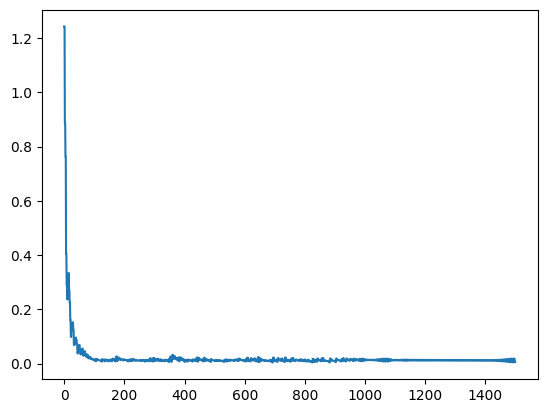

In [238]:
mask = True
num_epochs = 750
batch_size = 1

criterion = nn.MSELoss()
optimizer = optim.Adam(list(policy.parameters()), lr=0.001)

losses = []

idxs = np.array(range(len(trajs)))

num_batches = len(idxs) // batch_size
# Train the model with regular SGD
for epoch in range(num_epochs):  # loop over the dataset multiple times
    np.random.shuffle(idxs)
    running_loss = 0.0
    for i in range(num_batches):
        optimizer.zero_grad()

        #t_idx = np.random.randint(len(trajs), size=(batch_size,)) # Indices of traj
        #t_idx_pertraj = np.random.randint(1, size=(batch_size,)) # Indices of timesteps in traj
        #t_states = np.concatenate([trajs[c_idx]['masked_obs'][t_idx][None] for (c_idx, t_idx) in zip(t_idx, t_idx_pertraj)])
        #t_actions = np.concatenate([trajs[c_idx]['acts'][t_idx][None] for (c_idx, t_idx) in zip(t_idx, t_idx_pertraj)])
        t_states = trajs[0]['masked_obs']
        t_actions = trajs[0]['acts'].flatten()
        t_states = torch.Tensor(t_states).float().to(device)
        t_actions = torch.Tensor(t_actions).float().to(device)
        t_states = t_states.unsqueeze(0)
        t_actions = t_actions.unsqueeze(0)

        a_preds = policy(t_states)
        loss = torch.mean(torch.linalg.norm(a_preds - t_actions, dim=-1)) # supervised learning loss
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:
            print('[%d, %5d] loss: %.8f' %
                  (epoch + 1, i + 1, running_loss))
            losses.append(running_loss)
            running_loss = 0.0
        losses.append(loss.item())

print('Finished Training')
plt.plot(losses)

In [239]:
test = dill.load(open('laptop_trash.pkl','rb'))
test = test['masked_obs']

In [240]:
policy.eval()
t_states = test
t_states = torch.Tensor(t_states).float().to(device)
t_states = t_states.unsqueeze(0)
action = policy(t_states).cpu().detach()

In [241]:
action[0]

tensor([ 1.3398,  1.1372,  0.0845,  2.1463,  1.0047,  0.0851,  2.1404, -0.1486,
         0.0850,  1.3400, -0.3174,  0.0849])

In [232]:
t_actions

tensor([[ 1.3380,  1.1350,  0.0850,  1.3380,  0.5740,  0.0850,  1.3380,  0.1330,
          0.0850,  1.3380, -0.3190,  0.0850]])

In [3]:
test = dill.load(open('laptop_trash.pkl','rb'))
test = test['masked_obs']

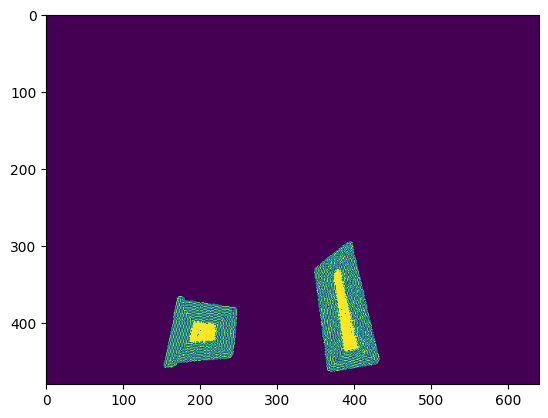

In [5]:
plt.imshow(test)